In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import operator

In [3]:
stats = pd.read_csv("stats.csv")
data = pd.read_excel('XYZ-1.xlsx','Data')
demand = data[6:]

In [4]:
stats

,Purchase Cost,Lead Time,Size,Selling Price,Starting Stock,Mean,Std Dev,Co,Ch,Probability,Demand_lead
0,12,9,0.570,16.1,2750,103.501805,37.317994,1000,20,0.756831,705
1,7,6,0.052,8.6,22500,648.551913,26.446797,1200,20,1.000000,3891
2,6,16,0.530,10.2,5200,201.677043,31.079301,1000,20,0.702186,2266
3,37,22,1.050,68.0,1400,150.068965,3.215598,1200,20,0.237705,785


<AxesSubplot:ylabel='Frequency'>

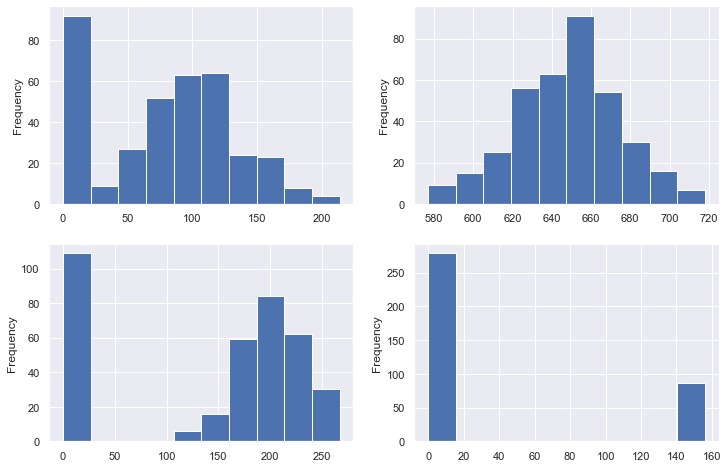

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
demand[1].plot.hist(ax=axes[0,0])
demand[2].plot.hist(ax=axes[0,1])
demand[3].plot.hist(ax=axes[1,0])
demand[4].plot.hist(ax=axes[1,1])

In [6]:
class Product:
    def __init__(self, i):
        # type i = int, i-> product number
        self.i = i
        self.unit_cost = stats['Purchase Cost'].iloc[i-1]
        self.lead_time = stats['Lead Time'].iloc[i-1]
        self.size = stats['Size'].iloc[i-1]
        self.selling_price = stats['Selling Price'].iloc[i-1]
        self.holding_cost = stats['Ch'].iloc[i-1]
        self.ordering_cost = stats['Co'].iloc[i-1]
        self.probability = stats['Probability'].iloc[i-1]
        self.starting_stock = stats['Starting Stock'].iloc[i-1]
        self.demand_lead = stats['Demand_lead'].iloc[i-1]

        self.mean = np.mean([np.log(j) for j in demand[demand[i]>0][i]])
        self.sd = np.std([np.log(j) for j in demand[demand[i]>0][i]])

In [7]:
# Now we draw from a log-Normal Distribution

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0,1)
    if random_num>probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

In [8]:
# Simulating Monte Carlo for 1 Year
# Periodic Review System - the inventory is checked and  reordering
# is done only in specific intervals of time
# For eg: bi-weekly, monthly, quarterly etc.
# In such a system, stock is replenished 
# only after a certain time period

def monte_carlo(M, product, review_period = 30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    q = 0
    stock_out = 0
    # A dict is created to store all information
    data = {'inv_level':[],'daily_demand':[],'units_sold':[],'units_lost':[],'orders':[]}
    for k in range(1,365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if k%(review_period+lead_time)==0:
            # Restocking takes place
            q = M - inventory
            data['orders'].append(q)
            inventory+=q
        if inventory-day_demand>0:
            data['units_sold'].append(day_demand)
            inventory-= day_demand
        elif inventory-day_demand<0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand-inventory)
            inventory=0
            stock_out+=1
        data['inv_level'].append(inventory)
    return data

In [12]:
def monte_carlo(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    # dict to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            # Placing the order
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            
            
        if order_placed:
            counter += 1
        
        if counter == lead_time:
            # Restocking day
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

In [16]:
def profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold'])*selling_price
    cost_of_ordering = len(data['orders'])*order_cost
    cost_of_holding = sum(data['inv_level'])*holding_cost*size*(1/days)
    cost = sum(data['orders'])*unit_cost

    profit_made = revenue-cost-cost_of_ordering-cost_of_holding
    return profit_made

In [17]:
def simulation(product, M, num_simulations=100):
    profit_list = []
    orders_lost_list = []
    for i in range(num_simulations):
        data = monte_carlo(M, product)
        profit_made = profit(data, product)
        profit_list.append(profit_made)

        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [18]:
product_1 = Product(1)
p_list = simulation(product_1, 3000, 1000)
print(np.mean(p_list), np.std(p_list))

39061.36592616699 39261.30139280373


<function matplotlib.pyplot.show(close=None, block=None)>

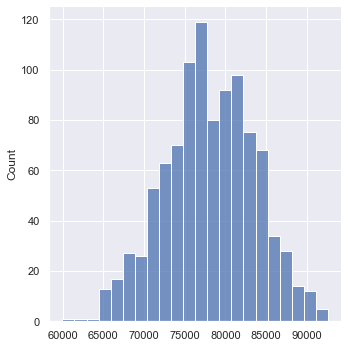

In [20]:
p_list, o_list = simulation(Product(1), 3000, 1000)
sns.displot(p_list)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

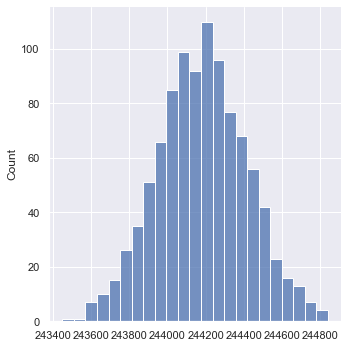

In [29]:
p_list, o_list = simulation(Product(2), 3000, 1000)
sns.displot(p_list)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

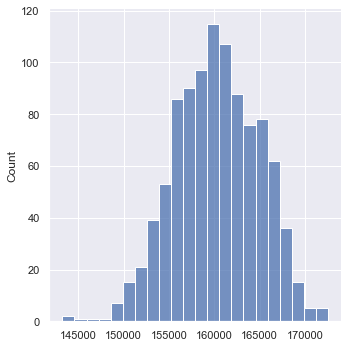

In [30]:
p_list, o_list = simulation(Product(3), 3000, 1000)
sns.displot(p_list)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

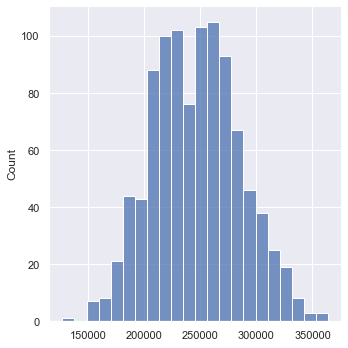

In [31]:
p_list, o_list = simulation(Product(4), 3000, 1000)
sns.displot(p_list)
plt.show

In [32]:
np.mean(p_list)

246416.2670777999

In [33]:
np.mean(o_list)

0.03165130812088347

In [34]:
np.std(p_list)

38822.54303892971

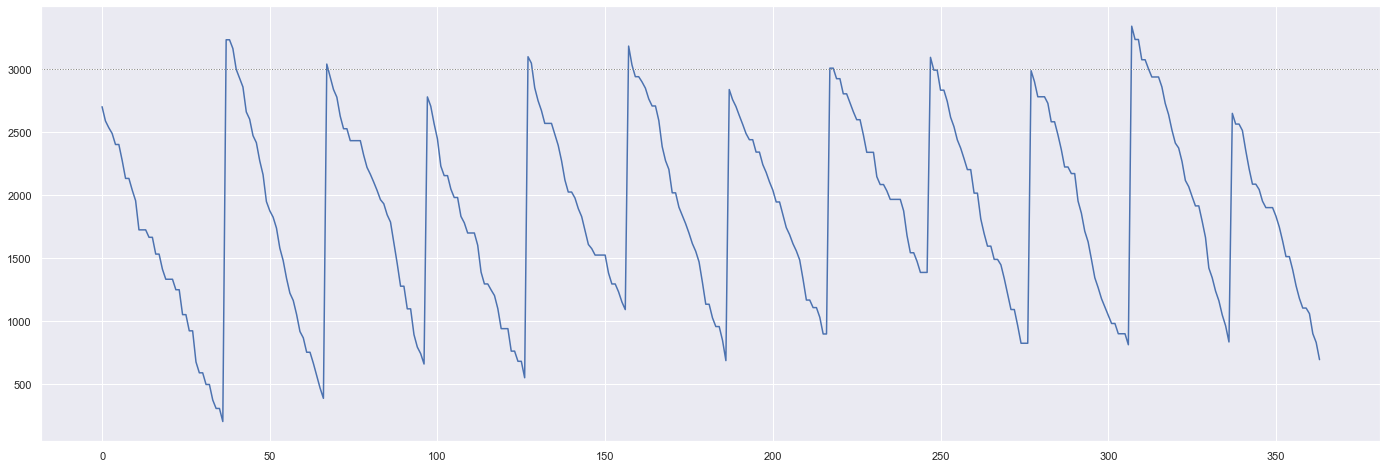

In [36]:
data = monte_carlo(3000, Product(1))
plt.figure(figsize = (24,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color="grey", linestyle=":")
plt.show()